## 개요

선수의 시장가격과 능력치 사이의 상관성이 존재하는가?

이를 알아보기 위해 FIFA에서 제공하는 데이터를 바탕으로 선수들의 가치를 확인해보고자 한다.

**평가 방식 - RMSE 점수**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 파일 불러오기
test_data = pd.read_csv('./data/FIFA_test.csv')
train_data = pd.read_csv('./data/FIFA_train.csv')

### FIFA_train.csv


|변수명           | 변수 설명                                          | 변수 타입| 타입 설명|
|------------------|:--------------------------------------------------:|------------|--------|
|**id**                | 선수 고유의 아이디                                 | int|
|**name**             | 이름                                               | string|
|**age**              | 나이                                               | int|15세부터 40세
|**continent**        | 선수들의 국적이 포함되어 있는 대륙                 | string|5개 대륙
|**contract_until**   | 선수의 계약기간                                    | object|
|**position**         | 선수가 선호하는 포지션 ex) 공격수, 수비수 등       | object|4개의 범주 구성(GK,DF,MF,ST)
|**prefer_foot**      | 선수가 선호하는 발 ex) 오른발                      | object|2개의 범주 구성(왼발,오른발)
|**reputation**       | 선수가 유명한 정도 ex) 높은 수치일 수록 유명한 선수|float|1.0부터 5.0까지 구성 - 5단계
|**stat_overall**     | 선수의 현재 능력치                                 | int|
|**stat_potential**   | 선수가 경험 및 노력을 통해 발전할 수 있는 정도     | int|
|**stat_skill_moves** | 선수의 개인기 능력치                               |float|1.0부터 5.0까지 구성 - 5단계
|**value**            | FIFA가 선정한 선수의 이적 시장 가격 (단위 : 유로)  |float|

In [3]:
train_data.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


In [23]:
train_data['continent'].value_counts()

europe           5322
south america    1927
asia              787
africa            721
oceania           175
Name: continent, dtype: int64

능력치가 같더라도 포지션,나이에 따라서 value의 가치가 다른지 확인하기

인기에따라 value가 다른지 확인하기

각 변수별 가중치,중요도 여부

value 간략하게 할 방법 찾기


In [4]:
# 중복되는 변수 확인
train_data.isnull().sum()

id                  0
name                0
age                 0
continent           0
contract_until      0
position            0
prefer_foot         0
reputation          0
stat_overall        0
stat_potential      0
stat_skill_moves    0
value               0
dtype: int64

In [5]:
# 변수별 정보 확인
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
id                  8932 non-null int64
name                8932 non-null object
age                 8932 non-null int64
continent           8932 non-null object
contract_until      8932 non-null object
position            8932 non-null object
prefer_foot         8932 non-null object
reputation          8932 non-null float64
stat_overall        8932 non-null int64
stat_potential      8932 non-null int64
stat_skill_moves    8932 non-null float64
value               8932 non-null float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


In [7]:
# 중복된 데이터 확인

train_data.duplicated().sum()

0

In [8]:
# reputation을 범주형으로
train_data['cat_reputation']= train_data['reputation'].astype('category')
train_data['cat_reputation'].dtype

CategoricalDtype(categories=[1.0, 2.0, 3.0, 4.0, 5.0], ordered=False)

In [9]:
# 고유 번호 삭제
del train_data['id']

In [10]:
# 이름을 인덱스로 지정
train_data.rename(index = train_data['name'],inplace = True)
del train_data['name']

In [11]:
train_data.head()

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value,cat_reputation
L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0,5.0
De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0,4.0
L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0,5.0
Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0,4.0
J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0,3.0


In [12]:
train_data.describe()

,age,reputation,stat_overall,stat_potential,stat_skill_moves,value
count,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8.932000e+03
mean,25.209136,1.130878,67.091133,71.997201,2.401702,2.778673e+06
std,4.635515,0.423792,6.854910,5.988147,0.776048,5.840982e+06
min,16.000000,1.000000,47.000000,48.000000,1.000000,1.000000e+04
25%,21.000000,1.000000,63.000000,68.000000,2.000000,3.750000e+05
50%,25.000000,1.000000,67.000000,72.000000,2.000000,8.250000e+05
75%,28.000000,1.000000,72.000000,76.000000,3.000000,2.600000e+06
max,40.000000,5.000000,94.000000,94.000000,5.000000,1.105000e+08


### Corr

In [13]:
# 상관계수 확인
train_corr = train_data.corr()

train_corr.round(2)

,age,reputation,stat_overall,stat_potential,stat_skill_moves,value
age,1.00,0.26,0.47,-0.23,0.04,0.09
reputation,0.26,1.00,0.52,0.40,0.20,0.67
stat_overall,0.47,0.52,1.00,0.67,0.40,0.66
stat_potential,-0.23,0.40,0.67,1.00,0.33,0.61
stat_skill_moves,0.04,0.20,0.40,0.33,1.00,0.30
value,0.09,0.67,0.66,0.61,0.30,1.00


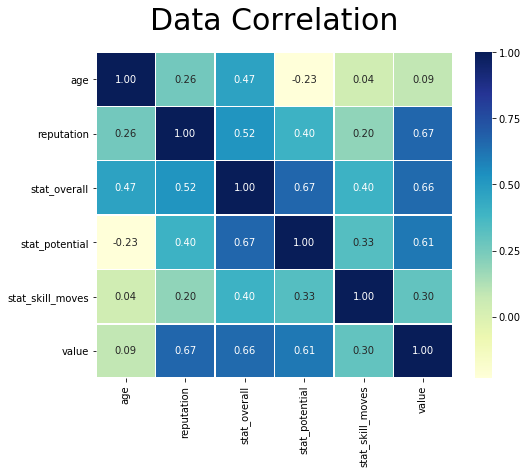

In [14]:
import seaborn as sns

f, ax = plt.subplots(figsize=(8,6))
plt.title("Data Correlation", fontsize=30, position=(0.5, 1.0+0.05))
sns.heatmap(train_corr, annot=True, fmt='.2f', linewidths=.5, ax=ax, cmap='YlGnBu')
plt.show()

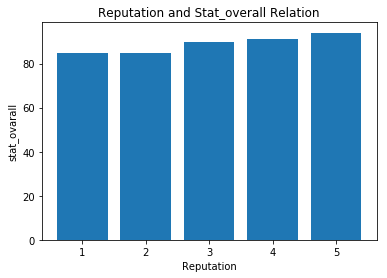

In [15]:
# 인기도별 stat 수치
plt.bar('cat_reputation','stat_overall',data = train_data)
plt.title('Reputation and Stat_overall Relation')
plt.xlabel('Reputation')
plt.ylabel('stat_ovarall')

plt.show()

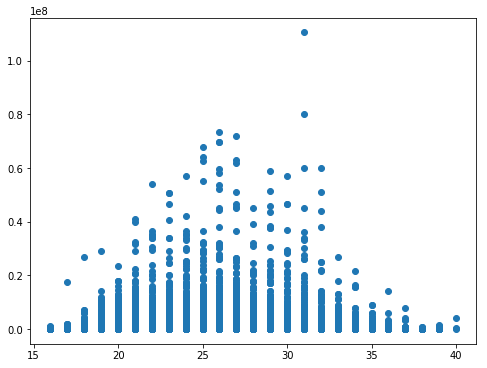

In [16]:
plt.figure(figsize = (8,6))

plt.scatter('age','value',data = train_data)

plt.show()

### pivot table

In [17]:
# 나이 15-19,20-24,25-29,30-34,35-39,40으로 분리
# include_lowest는 객체의 가장 작은 값을 포함 여부를 지정하는 것으로 기본값은 False로서 포함하지않음. 
# right = False이면 위 함수의 결과중의 한 구간을 (a, b]로 표시함.
# false(default)일 경우 a<x<b라는 의미 , True일 경우 [a, b] 즉,  a<x<=b

group_names = ['15-19', '20-24','25-29','30-34','35-39','40']

cut_age =  pd.cut(train_data['age'],[14,19,24,29,34,39,41], right= True, labels = group_names)

cut_age

L. Messi              30-34
De Gea                25-29
L. Suárez             30-34
Sergio Ramos          30-34
J. Oblak              25-29
D. Godín              30-34
David Silva           30-34
N. Kanté              25-29
M. ter Stegen         25-29
T. Courtois           25-29
Sergio Busquets       25-29
E. Cavani             30-34
M. Neuer              30-34
G. Chiellini          30-34
M. Salah              25-29
Casemiro              25-29
L. Insigne            25-29
Isco                  25-29
Coutinho              25-29
P. Aubameyang         25-29
M. Hummels            25-29
H. Lloris             30-34
G. Higuaín            30-34
G. Buffon                40
S. Umtiti             20-24
K. Koulibaly          25-29
P. Pogba              25-29
R. Lukaku             25-29
Jordi Alba            25-29
D. Mertens            30-34
                      ...  
M. Schantl            15-19
P. Paya               15-19
E. Bilen              15-19
S. Dawood             15-19
J. Granlund         

In [18]:
pd.value_counts(cut_age)

20-24    3244
25-29    2947
30-34    1526
15-19     984
35-39     228
40          3
Name: age, dtype: int64

In [19]:
train_data['cut_age'] = cut_age
train_data.head()

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value,cat_reputation,cut_age
L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0,5.0,30-34
De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0,4.0,25-29
L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0,5.0,30-34
Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0,4.0,30-34
J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0,3.0,25-29


In [20]:
train_data[train_data['age'] == 40]

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value,cat_reputation,cut_age
G. Buffon,40,europe,2019,GK,right,4.0,88,88,1.0,4000000.0,4.0,40
S. Bertoli,40,south america,2019,GK,right,1.0,73,73,1.0,270000.0,1.0,40
B. Castillo,40,south america,2021,GK,right,1.0,66,66,1.0,40000.0,1.0,40


In [24]:
# 나이 간략하게 범주화 시킬것

pos_pivot = train_data.pivot_table(values = 'value' , index = 'position', columns = 'cut_age', aggfunc = np.mean, fill_value = 0)

pos_pivot.round(2)

cut_age,15-19,20-24,25-29,30-34,35-39,40
position,,,,,,
DF,702062.50,2170379.81,2877910.37,2352071.82,782685.19,0.00
GK,632790.70,956472.30,4008547.79,2611527.78,414814.81,1436666.67
MF,728157.22,2996117.10,4105202.46,3347390.51,552327.59,0.00
ST,808083.70,2824937.69,4402847.99,4740039.22,1958714.29,0.00


In [25]:
# 스텟 간략하게 범주화
group_name = ['46-49','50-59','60-69','70-79','80-89','90-94']

cut_overall =  pd.cut(train_data['stat_overall'],[46,49,59,69,79,89,94], right= True, labels = group_name)

cut_overall

L. Messi              90-94
De Gea                90-94
L. Suárez             90-94
Sergio Ramos          90-94
J. Oblak              90-94
D. Godín              90-94
David Silva           90-94
N. Kanté              80-89
M. ter Stegen         80-89
T. Courtois           80-89
Sergio Busquets       80-89
E. Cavani             80-89
M. Neuer              80-89
G. Chiellini          80-89
M. Salah              80-89
Casemiro              80-89
L. Insigne            80-89
Isco                  80-89
Coutinho              80-89
P. Aubameyang         80-89
M. Hummels            80-89
H. Lloris             80-89
G. Higuaín            80-89
G. Buffon             80-89
S. Umtiti             80-89
K. Koulibaly          80-89
P. Pogba              80-89
R. Lukaku             80-89
Jordi Alba            80-89
D. Mertens            80-89
                      ...  
M. Schantl            50-59
P. Paya               50-59
E. Bilen              50-59
S. Dawood             50-59
J. Granlund         

In [26]:
pd.value_counts(cut_overall)

60-69    4619
70-79    2837
50-59    1126
80-89     326
46-49      17
90-94       7
Name: stat_overall, dtype: int64

In [27]:
# 스텟 간략하게 범주화 시킬것

train_data['cut_overall'] = cut_overall

In [28]:
pos_pivot = train_data.pivot_table(values = 'value' , index = 'position', columns = 'cut_overall', aggfunc = np.mean, fill_value = 0)

pos_pivot.round(2)

cut_overall,46-49,50-59,60-69,70-79,80-89,90-94
position,,,,,,
DF,47500.00,146518.52,600517.02,4141144.91,19704819.28,47500000
GK,51666.67,113916.67,473855.04,3353107.00,19512195.12,70000000
MF,53333.33,164324.32,719806.58,5128044.43,25675373.13,60000000
ST,60000.00,178397.13,780232.16,5375415.13,27176470.59,95250000


In [29]:
contract_df = train_data.groupby('contract_until').sum()
contract_df

,age,reputation,stat_overall,stat_potential,stat_skill_moves,value
contract_until,,,,,,
2018,8861,339.0,21194,22237,726.0,3.410000e+08
2019,62711,2645.0,156223,165532,5457.0,3.467005e+09
2020,51643,2300.0,136945,146325,4878.0,4.872020e+09
2021,56415,2578.0,153021,166253,5471.0,6.525970e+09
2022,18458,947.0,53893,58032,1982.0,4.489195e+09
2023,12617,589.0,35343,37883,1295.0,2.935870e+09
2024,267,19.0,964,1033,35.0,2.941000e+08
2025,59,4.0,213,252,11.0,4.216000e+07
2026,23,3.0,85,90,3.0,5.050000e+07


In [30]:
# 남은 계약기간 총합
con_value = train_data['contract_until'].value_counts()
con_value

2019            2366
2021            2308
2020            2041
2022             761
2023             506
Jun 30, 2019     501
2018             327
Dec 31, 2018      64
May 31, 2019      19
2024              12
Jan 31, 2019      10
Jun 30, 2020       9
2025               3
Jan 1, 2019        2
2026               1
May 31, 2020       1
Jan 12, 2019       1
Name: contract_until, dtype: int64

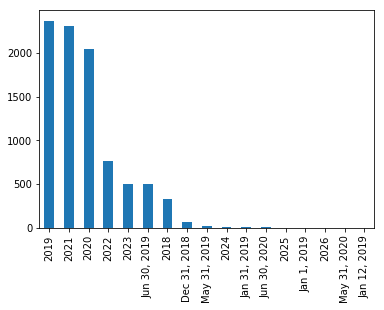

In [31]:
# 이거 간략하게 할 것

con_value.plot(kind = 'bar')
plt.show()

In [32]:
train_data['prefer_foot'].value_counts()

right    6837
left     2095
Name: prefer_foot, dtype: int64

변수별 중요도 측정